# t-SNE projection of Giardia spp. distance matrix

## Introduction


**Aim:**
Subsample a set of Giardia genomes to reduce overrepresentation of highly similar assemblies in a gene-by-gene schema


Project a distance matrix obtained using **mash** (kmer size = 51) to a vector space and then use clustering to determine the similarity among them. Finally, to obtain a curated set of genomes, we will conduct a grouped subsample. \

**Data input:**  Import a square matrix of pre-calculated mash distances (*sourmash v4.8.9*)

In [1]:
    # Import all dependencies 

import os
import sys
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as colormaps
from sklearn.manifold import TSNE
from sklearn.cluster import HDBSCAN


In [2]:
    # load the data    
sour_data = pd.read_csv('./sourmash_dist.csv', sep=',')

    # sanitize the labels
sour_data.columns = sour_data.columns.str.replace('.*/', '', regex=True)
sour_data.index = sour_data.columns
    

## t-SNE

### Hyperparameter tuning

This loop will show us different topologies according to the perplexity value (influence of neighbors in clustering)

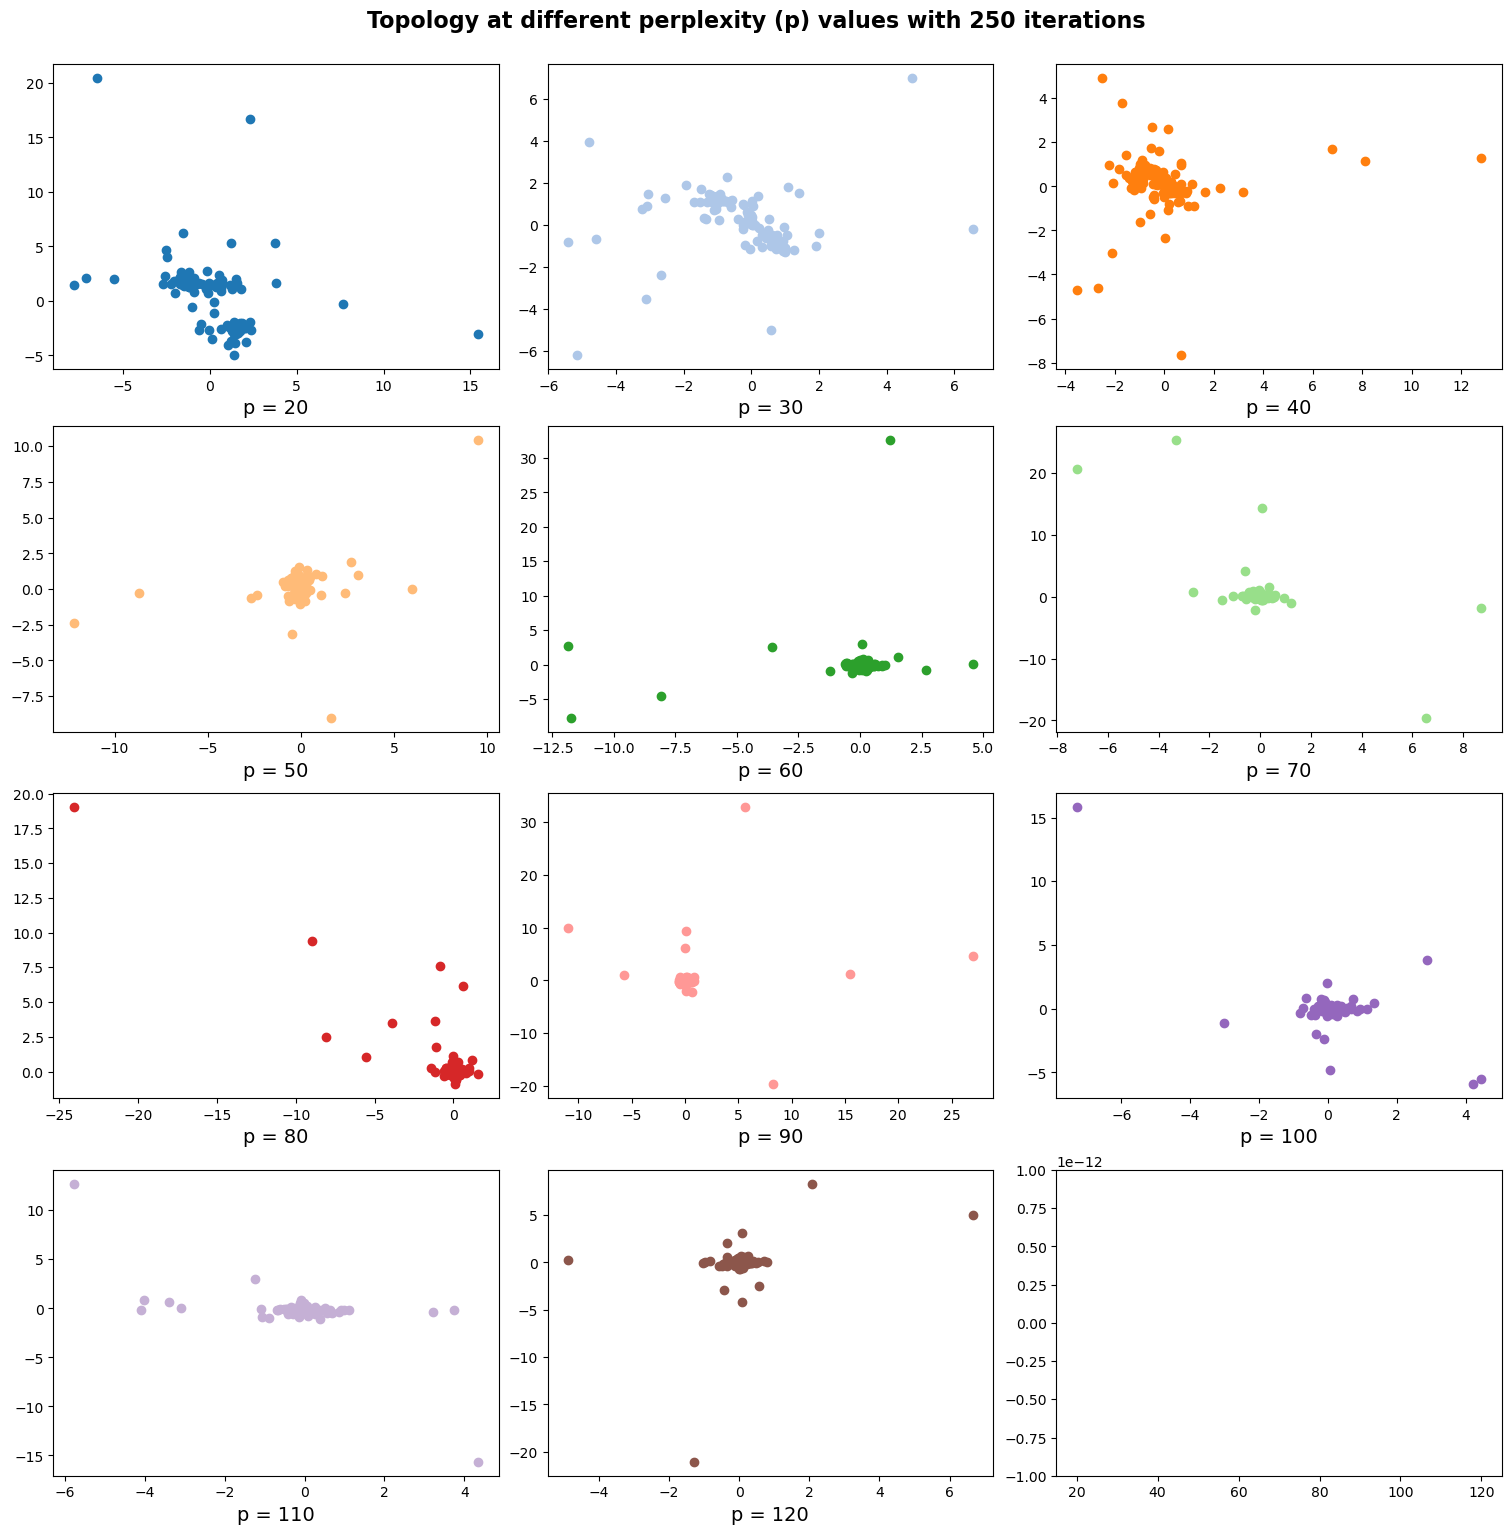

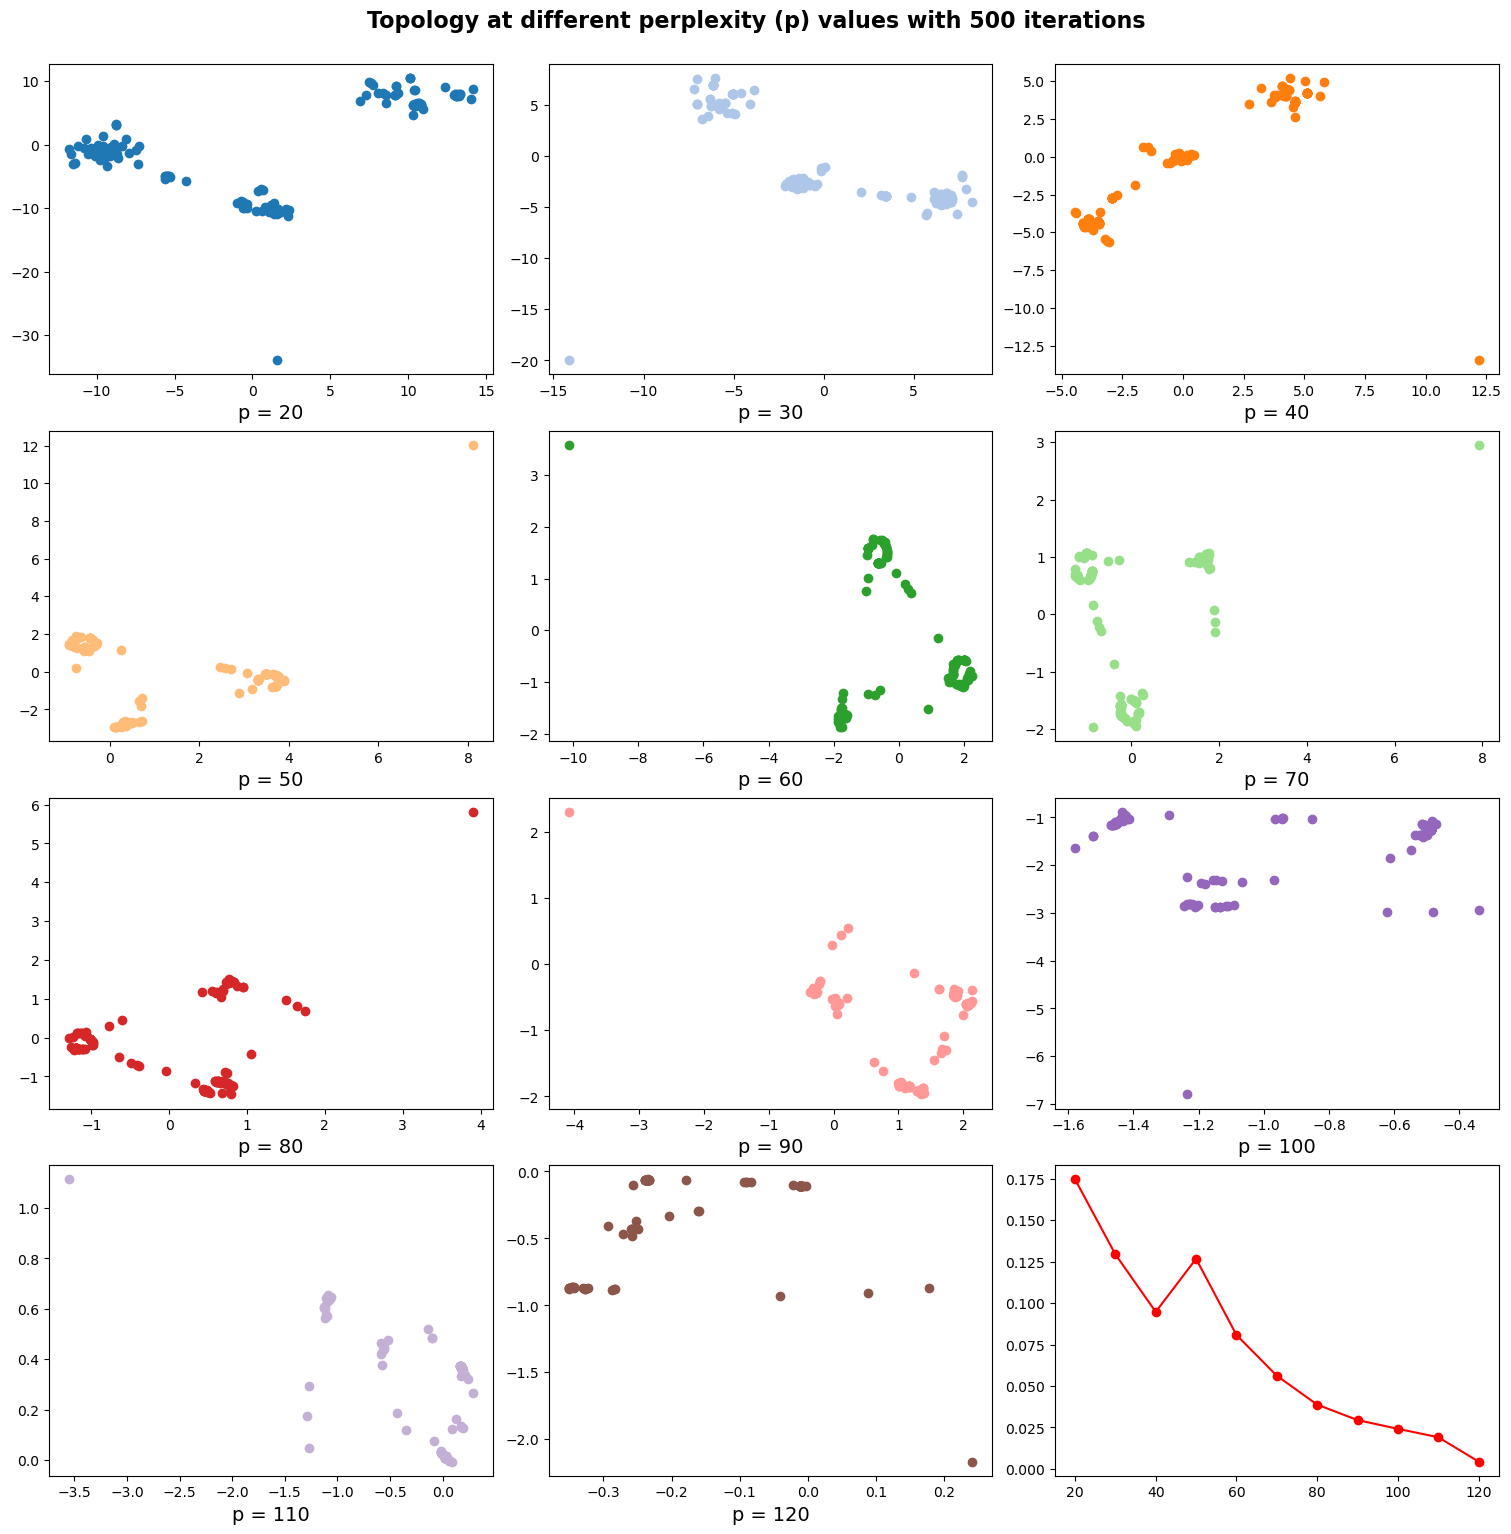

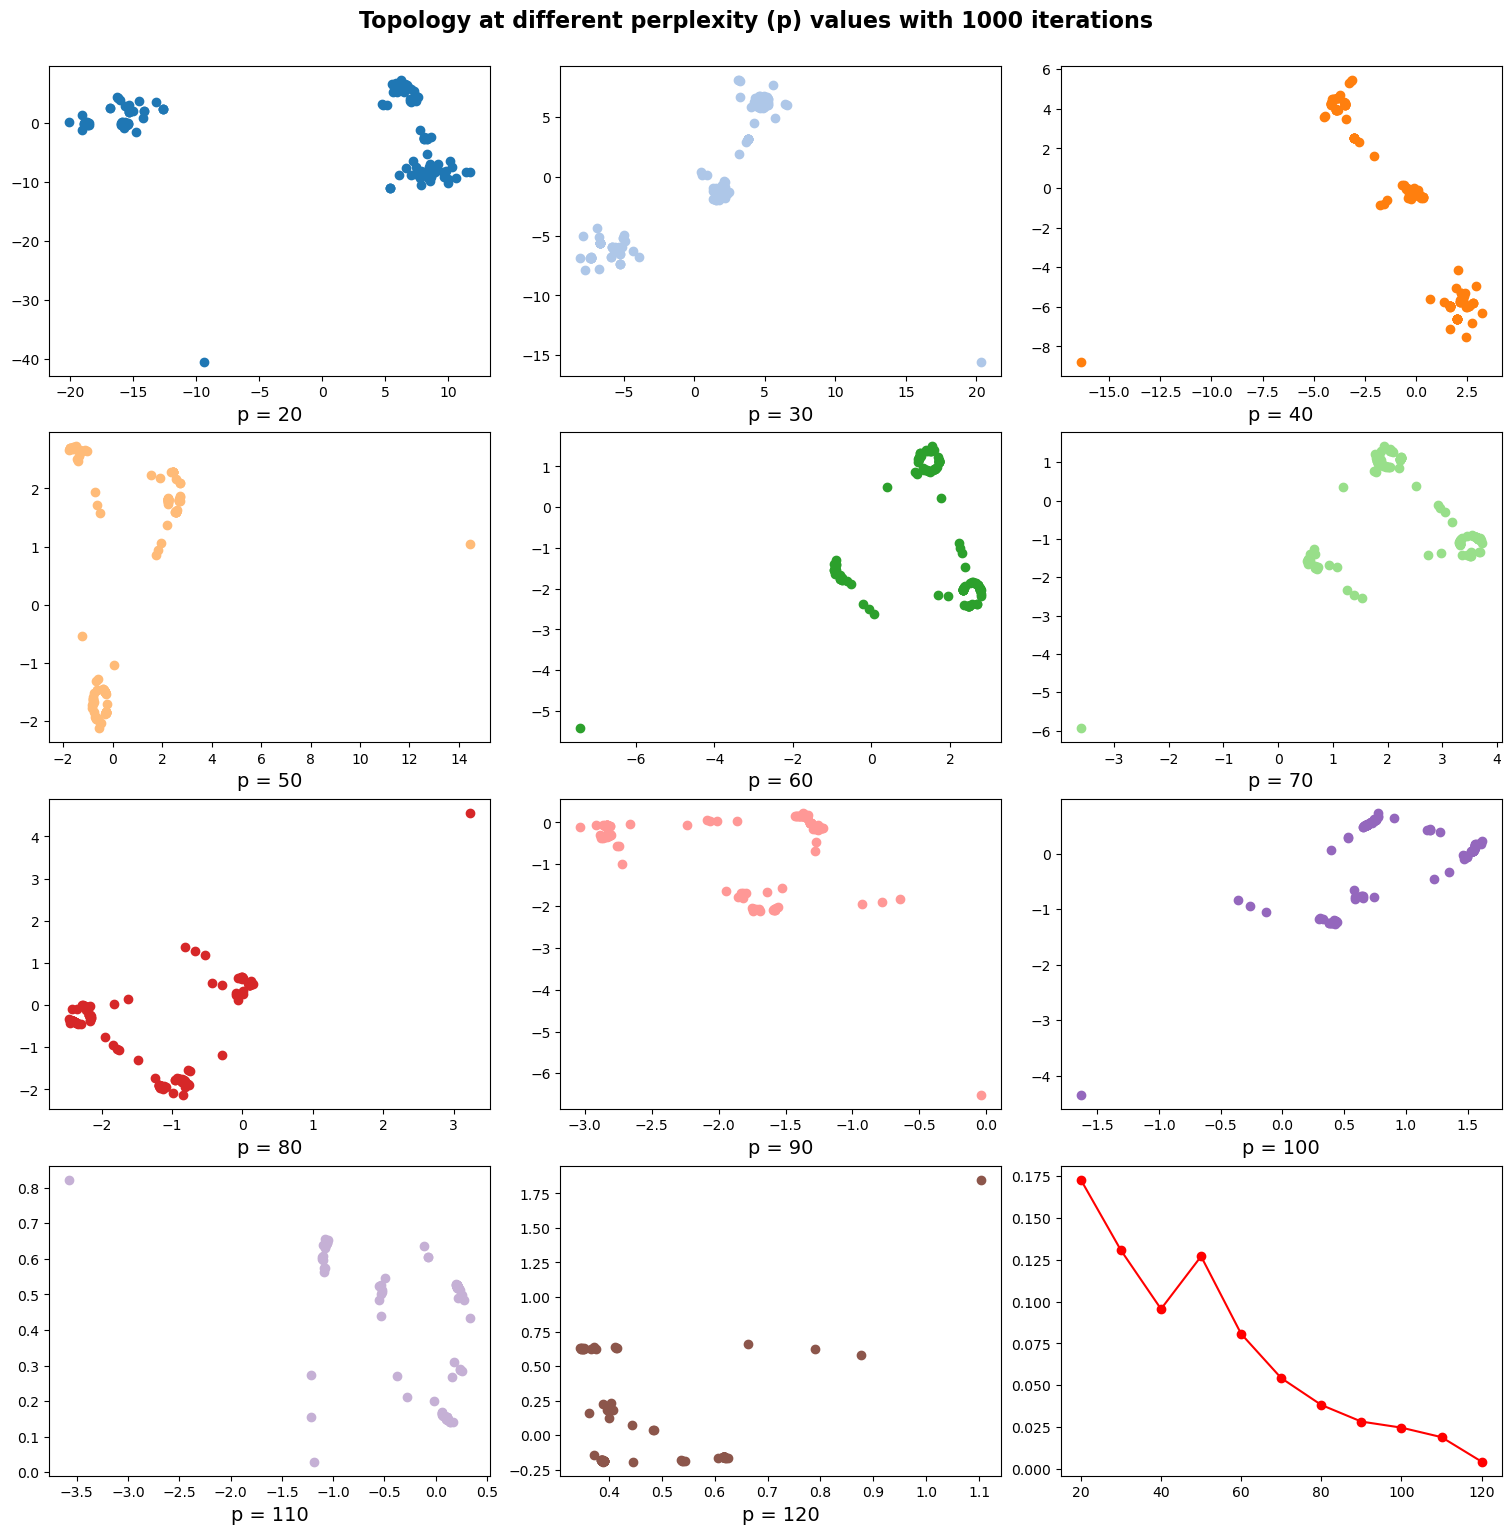

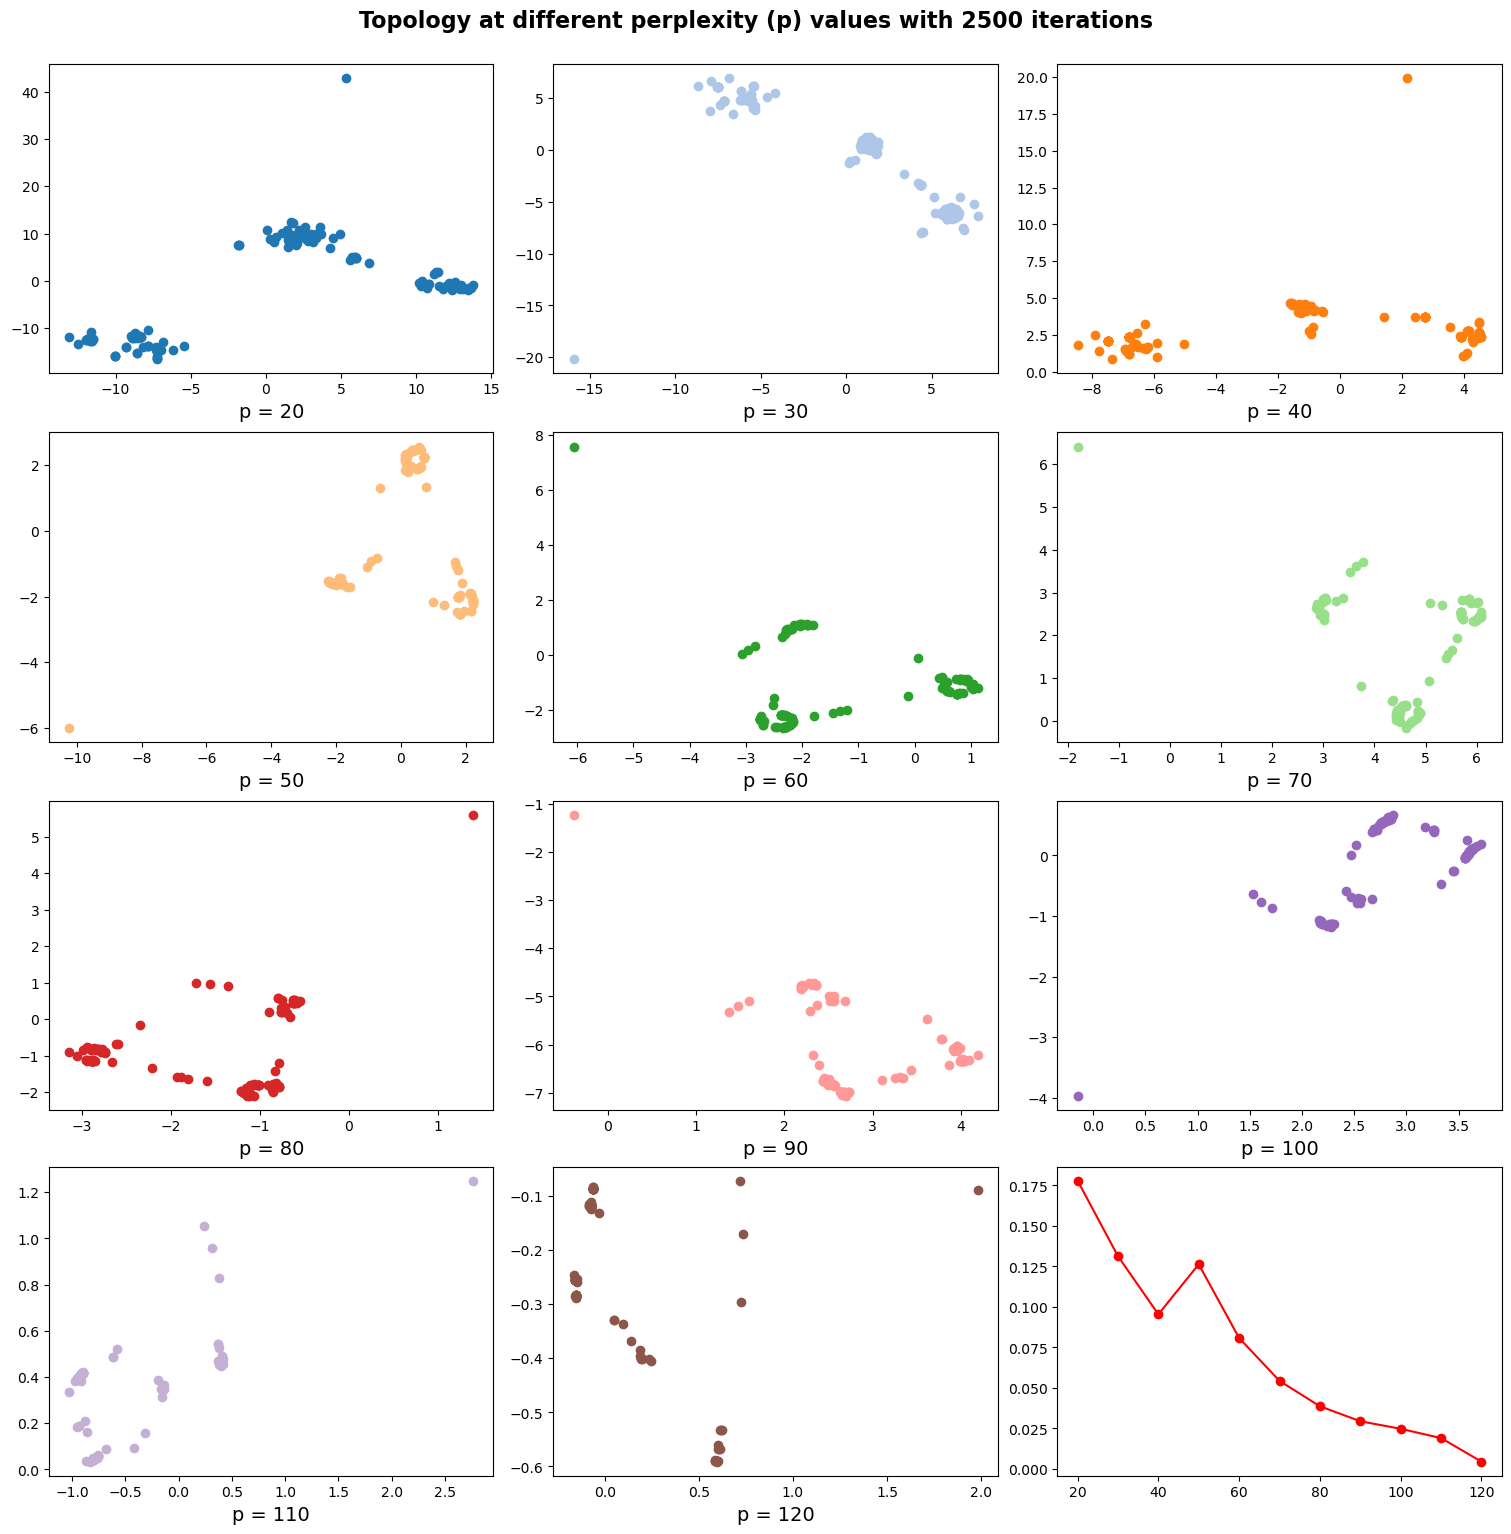

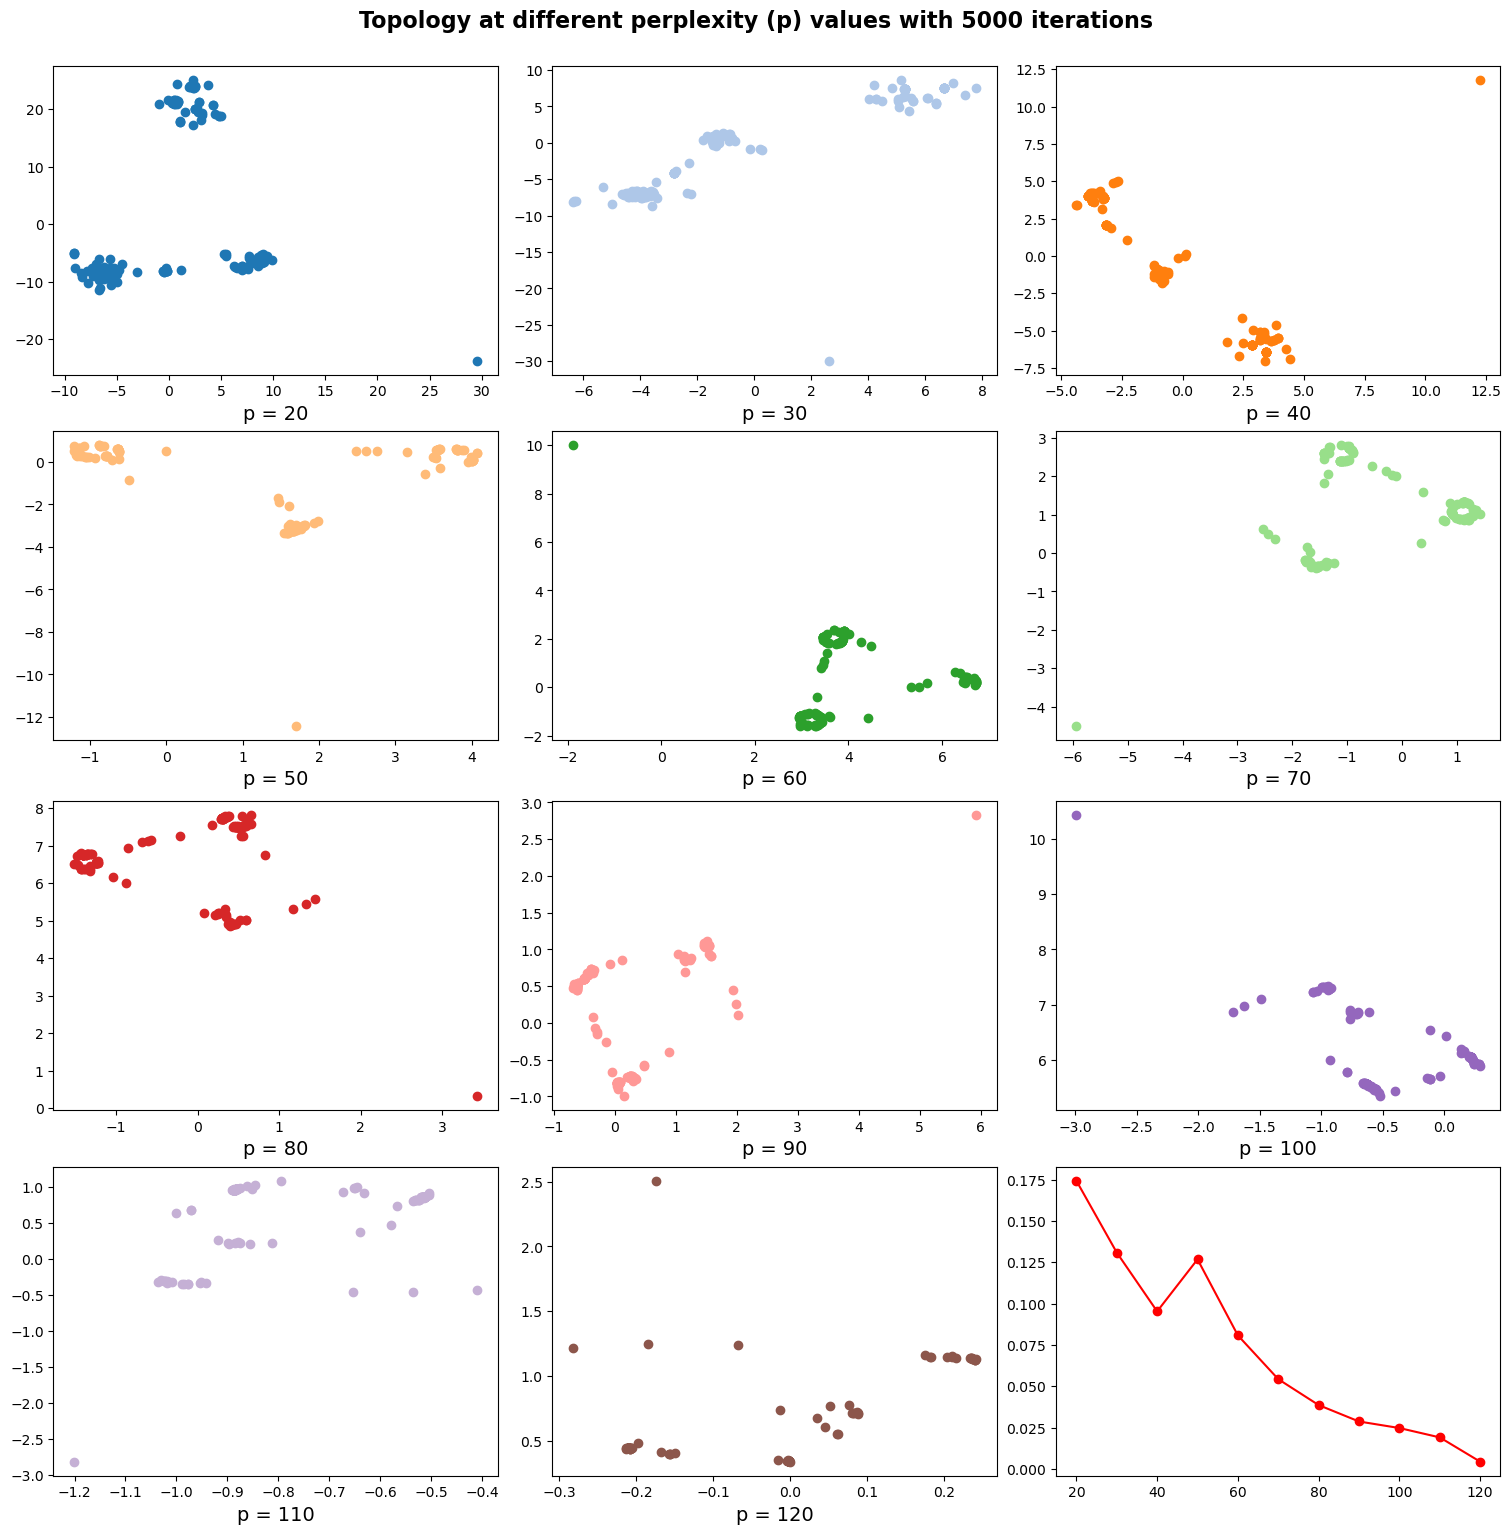

In [3]:
# define range of perplexity and iterations
perplexity = np.arange(20, 121, 10)
iters =  (250, 500, 1000, 2500, 5000)


# produce a multiplot of results by perplexity in the same max_iter value
for j in iters:
    
    # set divergence for each max_iter value
    divergence = []
    
    fig, axs = plt.subplots(4,3, figsize=(15,15), facecolor='w', layout="constrained")
    fig.suptitle("Topology at different perplexity (p) values with " +
                 str(j) + " iterations",  
                fontsize=16, va='bottom', weight='bold') 
    axs = axs.ravel()

    # evaluate fit [KL divergence] at given perplexity valuesv
    for index, p in enumerate(perplexity):
        
        # fit a TSNE model with precalculated matrix
        model = TSNE(
            n_components=2, 
            metric='precomputed', init="random",
            perplexity=p, max_iter=j)
        fitted = model.fit_transform(sour_data)
        divergence.append(model.kl_divergence_)
        
        # scatterplot of separation, each with a different color

        axs[index].scatter(fitted[:, 0], fitted[:,1], 
                        color=plt.cm.tab20(index) )
        axs[index].set_xlabel("p = " + str(p),
                            fontsize=14)
        
    # scatterplot of perplexity vs KL divergence coefficient
    plt.plot(
        perplexity, divergence, color='red', 
        marker='o', fillstyle='full')

We find convergence of clustering with at least 1000 iterations using a perplexity value above ~70. We run this model a few times too to make sure that the same topology is reproduced and then save a fitted model embeddings for further clustering.

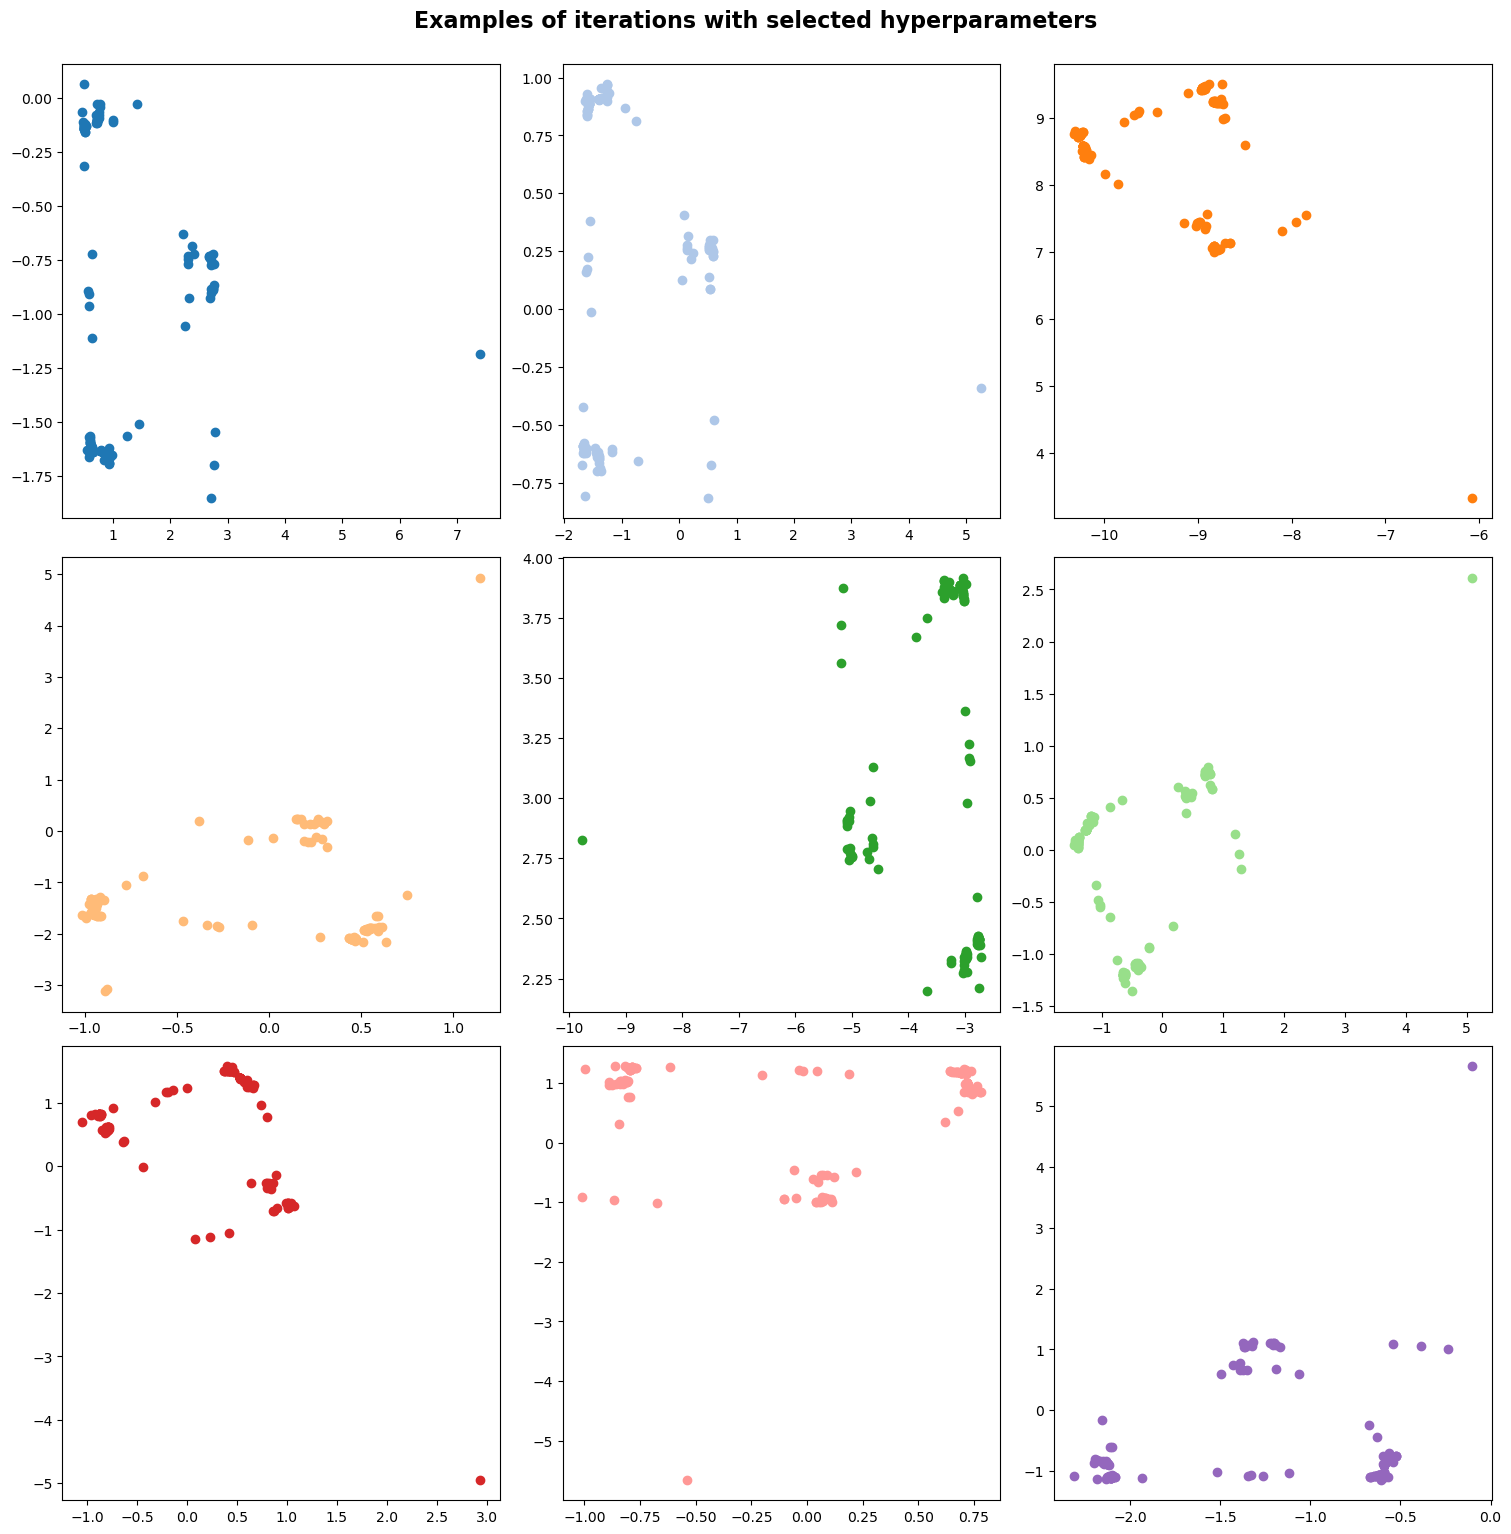

In [4]:
###### examples of the clustering
fig, axs = plt.subplots(3,3, figsize=(15,15), 
                facecolor='w', layout="constrained")
fig.suptitle("Examples of iterations with selected hyperparameters",
        fontsize=16, va='bottom', weight='bold') 
axs = axs.ravel()

for index in range(0,9):
        model = TSNE(n_components=2, metric="precomputed",
                     init="random", perplexity=90)
        fitted = model.fit_transform(sour_data)
        
        axs[index].scatter(fitted[:, 0], fitted[:, 1],
                           color=plt.cm.tab20(index))

###### saving the embeddings with a seed number so it is reproducible
tsne = TSNE(
        n_components=2, random_state=1113, 
        metric='precomputed', init="random",
        perplexity=90)

tsne = tsne.fit_transform(sour_data)

vector_mat = pd.DataFrame(tsne, columns=['t-SNE-1', 't-SNE-2'])
vector_mat.index= sour_data.index



## HDBSCAN clustering

### Define a ploting function

Imported a new plot that takes a numpy array and the clustering labels to produce a nice scatter plot colored by cluster and with a size that is relative to the probability of belonging to the cluster.

- Not all data points are clustered, the noise values are marked with a black "X"

In [5]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
        # transforms if inputs are pd.dataframe so the np operations can be performed
    if isinstance(X, pd.DataFrame):
        X = X.values  
    if isinstance(labels, pd.Series):
        labels = labels.values
        # creates a new ploting space is axes is not specified
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 7))
        # labels and probabilities are set to "1" if not specified
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
        # selects colors in spectra palette according to set number
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        # The probability of a point belonging to its labeled cluster determines
        # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=6 if k == -1 else 5 + 7 * proba_map[ci],
            )
        # Improve labelling
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" \n {parameters_str}"
    ax.set_title(title,  fontsize=14)
    plt.tight_layout()

### Parameter tuning

HDBSCAN will find the optimal epsilon automatically, but we should tune the `min_cluster_size` and the `min_samples` to define a core point. 

- We see that small `min_cluster_sizes` (~ 3) are not ideal as they create many small clusters with doubtful separation
- If we go above 30, it fails to select one region with obvious high density
- We want to be somehow conservative and only samples with a definitive association so better to go with an intermediate value like 10 or 15

In [ ]:
PARAM = ({"min_cluster_size": 3}, {"min_cluster_size": 5}, {"min_cluster_size": 7}, 
         {"min_cluster_size": 10}, {"min_cluster_size": 12}, {"min_cluster_size": 15}, 
         {"min_cluster_size": 20}, {"min_cluster_size": 25}, {"min_cluster_size": 30})

fig, axes = plt.subplots(3, 3, figsize=(12,18))
axes = axes.ravel()

for i, param in enumerate(PARAM):
    hdb = HDBSCAN(algorithm="auto", cluster_selection_method="eom", 
                           **param).fit(vector_mat)
    labels = hdb.labels_
    
    plot(vector_mat, labels, hdb.probabilities_, param, ax=axes[i])
    
    

Now we will check the importance of `min_samples` with minimum cluster sizes of 10 to define our final grouping approach

- We'll go with 10 for both parameters and then subsample the clusters. They may not be clearly defined but we do not want to lose a significant portion of our results

In [ ]:
PARAM = ({"min_cluster_size": 10, "min_samples": 3}, {"min_cluster_size": 10, "min_samples": 5},
         {"min_cluster_size": 10, "min_samples": 7}, {"min_cluster_size": 10, "min_samples": 10},
         {"min_cluster_size": 10, "min_samples": 12}, {"min_cluster_size": 10, "min_samples": 15},
         {"min_cluster_size": 10, "min_samples": 20}, {"min_cluster_size": 10, "min_samples": 25},
         {"min_cluster_size": 10, "min_samples": 40})
        

fig, axes = plt.subplots(3, 3, figsize=(12,18))
axes = axes.ravel()

for i, param in enumerate(PARAM):
    hdb = HDBSCAN(algorithm="auto", cluster_selection_method="eom",
                  **param).fit(vector_mat)
    labels = hdb.labels_
    
    plot(vector_mat, labels, hdb.probabilities_, param, ax=axes[i])
    
    

In [ ]:
hdb = HDBSCAN(algorithm="auto", cluster_selection_method="eom",
              min_cluster_size=10, min_samples=15)

hdb =hdb.fit(tsne_embeddings)

plot(vector_mat, labels=clusterer.labels_,
     probabilities=clusterer.probabilities_, ground_truth=False)

In [ ]:
hdb.condensed_tree_.plot(select_clusters=True)